In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import Polygon


import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from mitequinox.utils import *
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4677384.datarmor0/parcels-502090/libparcels_random_f22cea64-cdfe-40f0-9e40-81c7df3c58ca.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=6)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.144:38972 Dashboard: http://10.148.0.144:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load dataframe

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['mean_interp'])
df = p.df['mean_interp']

df = pa.degs2ms(df) #Convert in m/s 

#df = df.persist()

In [4]:
df_uv = df.drop(columns=[c for c in df.columns[6:9].append(df.columns[11:15]).values]) #drop sea level, temperature and salinity
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,SSU_interp,SSV_interp
npartitions=747,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [5]:
df_uv = df_uv.rename(columns={'SSU_interp':'zonal_velocity_interp','SSV_interp':'meridional_velocity_interp'})#.persist()

In [6]:
columns = ['zonal_velocity','meridional_velocity']
for V in columns:
    df_uv[V+'_prime'] = df_uv[V].sub(df_uv[V+'_interp'])
#df_uv = df_uv.persist()

In [7]:
df_uv['velocity_amplitude'] = np.sqrt(df_uv['zonal_velocity']**2+df_uv['meridional_velocity']**2)
df_uv['velocity_amplitude_interp'] = np.sqrt(df_uv['zonal_velocity_interp']**2+df_uv['meridional_velocity_interp']**2)
df_uv['velocity_amplitude_prime'] = np.sqrt(df_uv['zonal_velocity_prime']**2+df_uv['meridional_velocity_prime']**2)

In [8]:
df_uv = df_uv.persist()

### Binned statistics : 

In [8]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)


In [9]:
df_uv['lon'] = (df_uv['lon']+180)%360 - 180
df_uv['lon_cut'] = df_uv['lon'].map_partitions(pd.cut, lon_bins)
df_uv['lat_cut'] = df_uv['lat'].map_partitions(pd.cut, lat_bins)


In [10]:
#Square
for V in df_uv.columns[4:-2]:
    df_uv[V+'_sq'] = df_uv[V]**2

In [11]:
#df_uv['lon_mid'] = df_uv.lon_cut.apply(lambda r: r.mid)
#df_uv['lat_mid'] = df_uv.lat_cut.apply(lambda r: r.mid)
df_uv = df_uv.persist()

In [12]:
df_uv = df_uv.drop(columns=['zonal_velocity_interp','meridional_velocity_interp','velocity_amplitude_interp','zonal_velocity_interp_sq','meridional_velocity_interp_sq','velocity_amplitude_interp_sq'])

In [15]:
df_uv

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_prime,meridional_velocity_prime,velocity_amplitude,velocity_amplitude_prime,lon_cut,lat_cut,zonal_velocity_sq,meridional_velocity_sq,zonal_velocity_prime_sq,meridional_velocity_prime_sq,velocity_amplitude_sq,velocity_amplitude_prime_sq
npartitions=747,,,,,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,float64,float64,category[known],category[known],float64,float32,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Compute mean : 

In [13]:
df_mean = df_uv.groupby([df_uv.lon_cut, df_uv.lat_cut]).mean().compute()

df_mean = pa.add_geodata(df_mean)
#count['density'] = count['count']/count['area']

df_mean = (df_mean
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

### Store diagnostics

In [14]:
# Drop useless columns
df_mean = df_mean.drop(['z','trajectory'])

In [15]:
df_mean.attrs = {'run_name': run_name,'dl': dl}

In [16]:
df_mean

<xarray.Dataset>
Dimensions:                       (lat: 179, lon: 359)
Coordinates:
  * lon                           (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
Data variables: (12/13)
    zonal_velocity                (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity           (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime          (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime     (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude            (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_prime      (lon, lat) float64 nan nan nan ... nan nan nan
    ...                            ...
    meridional_velocity_sq        (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime_sq       (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime_sq  (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_sq         (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_prime_sq   (lon, lat) float64 nan nan nan ... nan nan nan
    area                          (lon, lat) float64 nan 49.22 ... 28.8 49.22
Attributes:
    run_name:  global_extra_T365j_dt1j_dij50
    dl:        1.0

In [17]:
#store dataset in diagnostics directory
p.store_diagnostic("L_dl"+str(dl)+"_stats", df_mean,overwrite=True)

L_dl1.0_stats diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/L_dl1.0_stats.zarr


### Load diagnostics

In [18]:
df_mean = p.load_diagnostic('L_dl1.0_stats.zarr')

In [19]:
df_mean.load()

<xarray.Dataset>
Dimensions:                       (lat: 179, lon: 359)
Coordinates:
  * lat                           (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5
  * lon                           (lon) float64 -179.5 -178.5 ... 177.5 178.5
Data variables: (12/13)
    area                          (lon, lat) float64 nan 49.22 ... 28.8 49.22
    meridional_velocity           (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime     (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_prime_sq  (lon, lat) float64 nan nan nan ... nan nan nan
    meridional_velocity_sq        (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude            (lon, lat) float64 nan nan nan ... nan nan nan
    ...                            ...
    velocity_amplitude_prime_sq   (lon, lat) float64 nan nan nan ... nan nan nan
    velocity_amplitude_sq         (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity                (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime          (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_prime_sq       (lon, lat) float64 nan nan nan ... nan nan nan
    zonal_velocity_sq             (lon, lat) float64 nan nan nan ... nan nan nan
Attributes:
    dl:        1.0
    run_name:  global_extra_T365j_dt1j_dij50

### Visualization : 

#### Mean flow : Lagrangian raw velocity, $<u>$

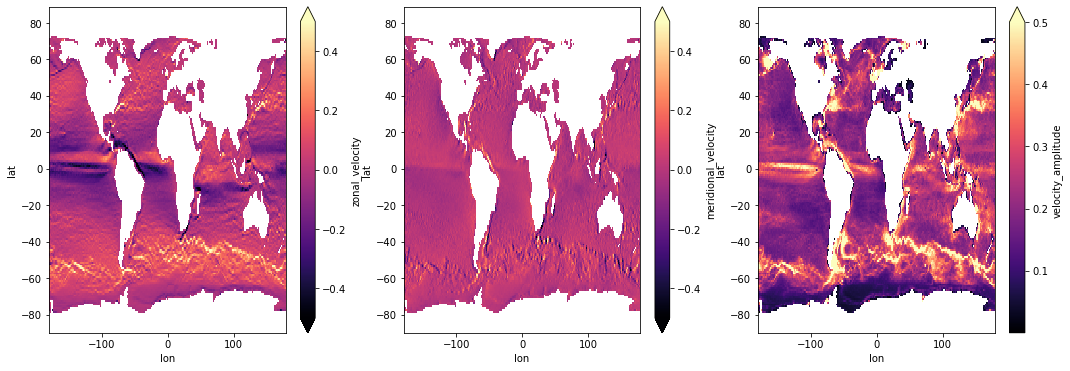

In [20]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')

#### Mean flow : Total velocity minus interpolated Eulerian mean, $<u_i'>=<u-\bar u_i>$

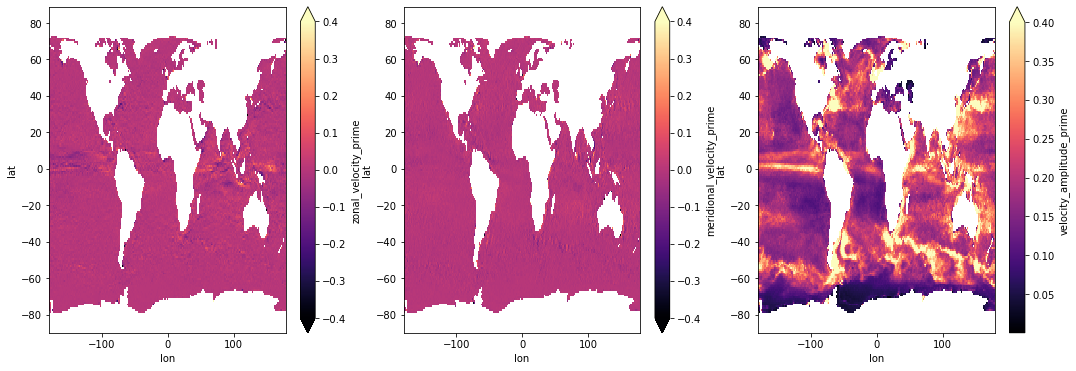

In [7]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')

#### Variance : $<u^2>$

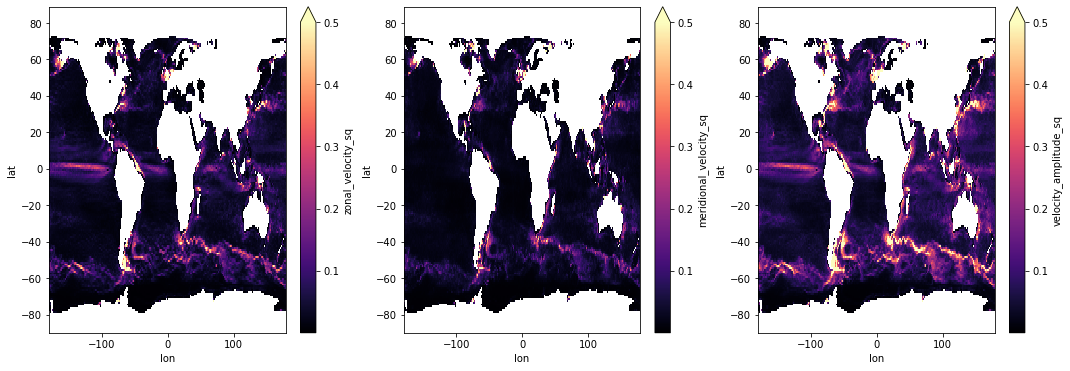

In [19]:
columns = ['zonal_velocity','meridional_velocity','velocity_amplitude']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.5,cmap='magma')

#### EKE : interpolated mean, $<u_i'^2>=<(u-\bar u_i)^2>$

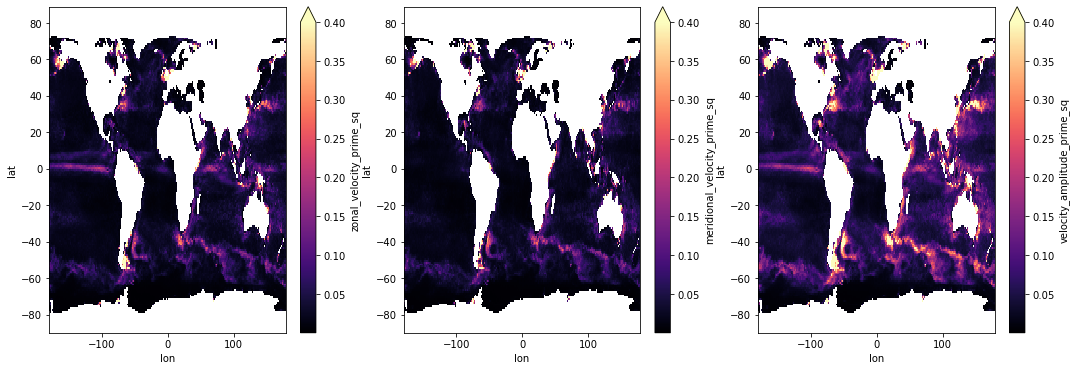

In [20]:
columns = ['zonal_velocity_prime','meridional_velocity_prime','velocity_amplitude_prime']
figsize=(6*len(columns),6)
fig,axs = plt.subplots(1,len(columns),figsize=figsize)#,subplot_kw=dict(projection=projection))
for V, ax in zip(columns,axs):
    df_mean[V+'_sq'].plot(ax=ax,x='lon',vmax=0.4,cmap='magma')

In [11]:
ds_mean = p.load_diagnostic('L_mean_std.zarr')


In [12]:
ds_mean = ds_mean.compute()

In [15]:
ds_test = ds_mean.to_dataframe().zonal_velocity_mean

In [21]:
df_test = df_uv.groupby('trajectory').get_group(49002013).compute()

In [30]:
df_test = df_test.set_index(['lat_mid','lon_mid'])

In [49]:
df_uv.lon_mid.compute()

time
2011-11-15 00:00:00   -178.5
2011-11-15 00:00:00   -178.5
2011-11-15 00:00:00   -178.5
2011-11-15 00:00:00   -178.5
2011-11-15 00:00:00   -178.5
                       ...  
2012-11-09 01:00:00    -35.5
2012-11-09 01:00:00    -29.5
2012-11-09 01:00:00    -33.5
2012-11-09 01:00:00    -32.5
2012-11-09 01:00:00    -34.5
Name: lon_mid, Length: 662785266, dtype: category
Categories (359, float64): [-179.5 < -178.5 < -177.5 < -176.5 ... 175.5 < 176.5 < 177.5 < 178.5]

In [50]:
df_uv.lat_mid.compute()

time
2011-11-15 00:00:00    57.5
2011-11-15 00:00:00    58.5
2011-11-15 00:00:00    59.5
2011-11-15 00:00:00    59.5
2011-11-15 00:00:00    60.5
                       ... 
2012-11-09 01:00:00    59.5
2012-11-09 01:00:00    59.5
2012-11-09 01:00:00    59.5
2012-11-09 01:00:00    57.5
2012-11-09 01:00:00    59.5
Name: lat_mid, Length: 662785266, dtype: category
Categories (179, float64): [-89.5 < -88.5 < -87.5 < -86.5 ... 85.5 < 86.5 < 87.5 < 88.5]

In [51]:
tst = df_uv.groupby(['lon_mid','lat_mid']).get_group((-178.5,57.5)).compute()

KeyboardInterrupt: 

In [ ]:
tst

In [34]:
df_uv.merge(ds_test)
#df_uv = df_uv.set_index(['lat_mid','lon_mid'])

ValueError: right must be DataFrame

In [26]:
df_uv.zonal_velocity.size.compute()

662785266

In [17]:
df_test.groupby(['lon_cut','lat_cut']).

In [18]:
df_test['lon_mid'] = df_test.lon_cut.apply(lambda r: r.mid)
df_test['lat_mid'] = df_test.lat_cut.apply(lambda r: r.mid)

In [22]:
df_bin_mean['zonal_velocity_mean'].sel(lat=np.unique(df_test.lat_mid),lon=np.unique(df_test.lon_mid))

<xarray.DataArray 'zonal_velocity_mean' (lon: 5, lat: 2)>
array([[0.04643704, 0.04347301],
       [0.06530332, 0.04791333],
       [0.05641532, 0.0574535 ],
       [0.04307133, 0.06401262],
       [0.0395273 , 0.05282464]])
Coordinates:
  * lat      (lat) float64 57.5 58.5
  * lon      (lon) float64 -36.5 -35.5 -34.5 -33.5 -32.5

In [14]:
def myfunc(df,ds_mean,V):
    mean_val = ds_mean[V+'_mean'].sel(lat=np.unique(df.lat_mid.values),lon=np.unique(df.lon_mid.values))
    df[V+'_sub'] = df[V]-mean_val.values[0]
    return df

In [25]:
df_test.groupby(['lon_mid','lat_mid']).apply(myfunc,df_bin_mean,'zonal_velocity')

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_interp,meridional_velocity_interp,zonal_velocity_prime,meridional_velocity_prime,velocity_amplitude,velocity_amplitude_interp,velocity_amplitude_prime,lon_cut,lat_cut,lon_mid,lat_mid,zonal_velocity_sub
time,,,,,,,,,,,,,,,,,,
2012-08-21 00:00:00,49002013,58.167522,-36.034992,0.0,0.000000,0.000000,0.043692,0.022113,-0.043692,-0.022113,0.000000,0.048969,0.048969,"(-37.0, -36.0]","(58.0, 59.0]",-36.5,58.5,-0.043473
2012-08-21 01:00:00,49002013,58.164337,-36.036138,0.0,-0.008396,-0.127468,0.043637,0.022251,-0.052033,-0.149718,0.127744,0.048982,0.158502,"(-37.0, -36.0]","(58.0, 59.0]",-36.5,58.5,-0.051869
2012-08-21 02:00:00,49002013,58.162857,-36.036038,0.0,-0.021908,-0.071902,0.043659,0.022293,-0.065567,-0.094196,0.075166,0.049021,0.114769,"(-37.0, -36.0]","(58.0, 59.0]",-36.5,58.5,-0.065381
2012-08-21 03:00:00,49002013,58.163168,-36.033603,0.0,0.025458,-0.018639,0.043651,0.022290,-0.018193,-0.040929,0.031552,0.049013,0.044790,"(-37.0, -36.0]","(58.0, 59.0]",-36.5,58.5,-0.018015
2012-08-21 04:00:00,49002013,58.164457,-36.030912,0.0,0.053142,0.031452,0.043655,0.022284,0.009486,0.009169,0.061752,0.049014,0.013193,"(-37.0, -36.0]","(58.0, 59.0]",-36.5,58.5,0.009669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-08 21:00:00,49002013,57.932636,-32.548978,0.0,0.059981,-0.281838,0.030170,0.008229,0.029811,-0.290067,0.288150,0.031272,0.291595,"(-33.0, -32.0]","(57.0, 58.0]",-32.5,57.5,0.020454
2012-11-08 22:00:00,49002013,57.926470,-32.548640,0.0,0.008174,-0.225797,0.033475,0.008914,-0.025301,-0.234711,0.225944,0.034642,0.236070,"(-33.0, -32.0]","(57.0, 58.0]",-32.5,57.5,-0.031353
2012-11-08 23:00:00,49002013,57.921829,-32.548579,0.0,0.002887,-0.158642,0.037014,0.009910,-0.034127,-0.168552,0.158668,0.038318,0.171972,"(-33.0, -32.0]","(57.0, 58.0]",-32.5,57.5,-0.036641


In [17]:
df_test2 = df_uv.get_partition(0).persist()

In [30]:
df_test2['lon_mid'] = df_test2.lon_cut.apply(lambda r: r.mid)
df_test2['lat_mid'] = df_test2.lat_cut.apply(lambda r: r.mid)
df_test2 = df_test2.persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lon_cut', 'category'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func

In [19]:
df_test2.groupby(['lon_mid','lat_mid']).apply(myfunc,ds_mean,'zonal_velocity').persist()

<ipython-input-19-21d90e7b7e5a>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_test2.groupby(['lon_mid','lat_mid']).apply(myfunc,ds_mean,'zonal_velocity').persist()


,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,zonal_velocity_interp,meridional_velocity_interp,zonal_velocity_prime,meridional_velocity_prime,velocity_amplitude,velocity_amplitude_interp,velocity_amplitude_prime,lon_cut,lat_cut,lon_mid,lat_mid,zonal_velocity_sub
npartitions=1,,,,,,,,,,,,,,,,,,
,int32,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,category[known],category[known],category[known],category[known],float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [15]:
meta = {V : 'f8' for V in df_uv.columns}

In [16]:
meta.update({'zonal_velocity_sub':'f8'})
df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,ds_mean,'zonal_velocity',meta=meta).persist()
#df_uv = df_uv.groupby(['lon_cut','lat_cut']).apply(myfunc,df_bin_mean,'meridional_velocity')

In [102]:
df_uv = df_uv.persist()

#### Total velocity minus binned Lagrangian mean, $u'_b$ : 

In [21]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
